In [144]:
# Import libraries
import numpy as np
import pandas as pd
import csv
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from collections import Counter
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA 

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split

from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from matplotlib import pyplot
import random

from datetime import datetime, timedelta

from pickle import dump, load

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion 

In [150]:
# Load training dataset
filename = 'data\TRAIN_CLAIM_FL_ALL_GROUPED.csv'
dataset = pd.read_csv(filename, low_memory=False)
print(dataset.shape)

(13230, 247)


In [151]:
# Extract the target variable and checking the class distribution
target = dataset['target']
print(Counter(target))

Counter({0: 7427, 1: 5803})


In [153]:
######################################################################################################
#Data exploratory
#####################################################################################################

# Filter Eligibles variables for the model (we did not drop provider_id and maxdos because they are goint to be used to split data)
collist = dataset.columns.tolist()
columnsToDrop = np.array(['claim_id', 'insured_id', 'specialty', 'facility_state', 'group_plan_id', 'mindos', 
                          'claim_line_id', 'cdt_code', 'cpt_code_classification', 'lb_cdt_code', 
                          'lb_cpt_code_classification', 'lb_specialty'
                          
                         ])
for c in columnsToDrop:
    collist.remove(c)
datasetFiltered = dataset[collist]

# Dataset shape
print(datasetFiltered.shape)

# Find columns with any missing values
columnsDF = pd.DataFrame(datasetFiltered.isnull().any(), columns = np.array(['hasMissing']))
print(columnsDF.query('hasMissing == True'))

# Find rows with any missing values
null_data = datasetFiltered[datasetFiltered.isnull().any(axis=1)]
print(null_data.shape[0])

# Ignore those rows with missing data
datasetFiltered = datasetFiltered.dropna()

# Extract the target variable and checking the class distribution
target = datasetFiltered['target']
datasetFiltered = datasetFiltered.drop('target', 1)
print(Counter(target))

# Extract the provider_id and DOS variables for future split
provider_id = datasetFiltered['provider_id']
datasetFiltered = datasetFiltered.drop('provider_id', 1)
maxdos = datasetFiltered['maxdos']
datasetFiltered = datasetFiltered.drop('maxdos', 1)

# Descriptive stats
pd.DataFrame(datasetFiltered.describe()).to_csv('descriptive_stats.csv')

# Skew for each attribute 
pd.DataFrame(datasetFiltered.skew()).to_csv('skew.csv')

# Correlations
pd.DataFrame(datasetFiltered.corr(method='pearson')).to_csv('correlations.csv')

# Are there constant variables?
constant = datasetFiltered.loc[:, datasetFiltered.apply(pd.Series.nunique) == 1]
print(constant.columns)

# Checking some variable importance
selector = SelectKBest(score_func=f_classif, k=10)
fit = selector.fit(datasetFiltered, target)

varImp = dict()
for variable, score, topX in zip(datasetFiltered.columns, fit.scores_, selector.get_support()):
    varImp[variable] = score
pd.DataFrame.from_dict(varImp, orient='index').to_csv('varImp.csv')



(13230, 235)
                             hasMissing
qtdclaimsprovider                  True
qtdclaimlinesprovider              True
qtdmemberprovider                  True
avgticketperclaimprovider          True
avgticketpermemberprovider         True
avgclaimspermemberprovider         True
avgclaimlineperclaimprovider       True
qtdclaimsmember                    True
qtdclaimlinesmember                True
qtdprovidermember                  True
avgticketperclaimmember            True
avgticketperprovidermember         True
avgclaimsperprovidermember         True
avgclaimlineperclaimmember         True
provider_age_time_of_service       True
amount_paid                        True
133
Counter({0: 7333, 1: 5764})
Index(['source', '8080'], dtype='object')


In [154]:
######################################################################################################
#Feature selecion
#####################################################################################################

# Drop some correlated variables (manual analysis - greater than 0.6)
collist = datasetFiltered.columns.tolist()
columnsHighCorr_GT06 = np.array(['has_radiography','4355','is_member_under_10','9230','amount_claim','0230','amount_cost',
                                 '2391','2933','PREVENTIVE','has_bitewing','2392','1120','7140','8220', '9310',
                                 'has_stainless_steel_crowns','2930','ADJ','0272','has_pulpotomies','3220','1351',
                                 'has_molar','RESTORATIVE', '3330', 'avgticketpermemberprovider', 'avgticketperclaimmember', 
                                 'avgticketperprovidermember', 'qtdmemberprovider', 'qtdclaimsmember', 'qtdclaimsprovider', 
                                 'avgclaimsperprovidermember',
                                 'avg_total_comb1', 'max_total_comb1', 'avg_zscore_comb1', 'min_zscore_comb1', 
                                 'max_zscore_comb1', 'avg_total_comb2', 'avg_zscore_comb2', 'max_zscore_comb2', 
                                 'avg_zscore_comb3', 'max_zscore_comb3', 'avg_zscore_comb4', 'max_zscore_comb4',
                                 'sum_total_comb1351', 'avg_total_comb1351', 'min_total_comb1351', 'max_total_comb1351', 
                                 'sum_total_comb0272','avg_total_comb0272', 'min_total_comb0272', 'max_total_comb0272',
                                 'sum_total_comb2', 'max_total_comb2', 'sum_total_comb3', 'avg_total_comb3', 
                                 'max_total_comb3','sum_total_comb4', 'avg_total_comb4', 'max_total_comb4',
                                 'sum_total_comb3220', 'avg_total_comb3220', 'max_total_comb3220', 'indicator_6_eligible',
                                 'indicator_8_eligible', 'indicator_9_eligible', 'indicator_13_eligible', 
                                 'indicator_14_eligible', 'indicator_16_eligible', 'indicator_9_result', 
                                 'indicator_17_result', 'min_total_comb2', 'min_zscore_comb2', 'min_total_comb3',
                                 'min_total_comb4', 'min_zscore_comb3', 'min_ratio_1351', 'max_ratio_1351', 'min_ratio_3220',
                                 'max_ratio_3220', 'min_ratio_0272', 'max_ratio_0272', 'indicator_7_eligible', 
                                 'indicator_10_eligible', 'avg_total_combrest', 'min_total_combrest', 'max_total_combrest',
                                 'min_ratio_rest', 'max_ratio_rest', 'sum_total_comb1', 'avgclaimlineperclaimmember',
                                 'indicator_17_eligible', 'FQHC', '5120', '0260', 'source', '8080', 'indicator_2_eligible', 
                                 'indicator_11_eligible', 'indicator_12_eligible', 'min_total_comb3220',
                                 'sum_total_combrest', 'avg_ratio_1351', 'avg_ratio_3220', 'avg_ratio_0272', 
                                 'avg_ratio_rest'
                                
                                ])

for c in columnsHighCorr_GT06:
    if c in collist:
        collist.remove(c)
datasetWithoutCorr = datasetFiltered[collist]

# Drop some variables with low importance (p-value < 0.05)
filtered_dict = {k:v for (k,v) in varImp.items() if v < 0.05}
columnsLowImp = list(filtered_dict.keys())

collist = datasetWithoutCorr.columns.tolist()
for c in columnsLowImp:
    if c in collist:
        collist.remove(c)
datasetHighImp = datasetWithoutCorr[collist]

# Dataset dim
print(datasetHighImp.shape)

# New correlations
pd.DataFrame(datasetHighImp.corr(method='pearson')).to_csv('correlations.csv')

# Checking some variable importance
selector = SelectKBest(score_func=f_classif, k=28)
fit = selector.fit(datasetHighImp, target)

varImp = dict()
for variable, score, topX in zip(datasetHighImp.columns, fit.scores_, selector.get_support()):
    varImp[variable] = score
pd.DataFrame.from_dict(varImp, orient='index').to_csv('varImp.csv')

# Show the top N most important features
kbest = datasetHighImp.ix[0:10:,selector.get_support()]
print(kbest.columns)


(13097, 112)
Index(['avgclaimspermemberprovider', 'avgclaimlineperclaimprovider',
       'member_age_time_of_service', 'provider_age_time_of_service',
       'amount_paid', 'has_primary_tooth', 'min_total_comb1',
       'min_zscore_comb4', '120', '140', '1203', '230', '250', 'PERIODONTICS',
       '274', '2140', '290', '330', 'OTHER NON-DENTAL', '240', '272', '3240',
       '260', '350', '3120', '4211', 'DIAGNOSTIC', '1208'],
      dtype='object')


In [155]:
columnsLowImp

['GD',
 '2390',
 '7111',
 'PEDO',
 '4341',
 '1515',
 '7510',
 'min_total_comb3220',
 '5820',
 'has_ob_ol_surface',
 '7310',
 '3221',
 'indicator_11_eligible',
 '2751',
 '1201',
 'indicator_6_result',
 '1555',
 '2393']

In [163]:
######################################################################################################
# Some "global" parameters
#####################################################################################################
seed = 7
scoring = 'precision'
test_size = 0.25
n_splits = 10
kfold = KFold(n_splits=n_splits, random_state=seed) 

In [157]:
######################################################################################################
# Random split
#####################################################################################################

# Prepare the dataset
X = datasetHighImp.values
Y = target

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

In [134]:
######################################################################################################
# Provider split
#####################################################################################################

# Append provider_id + target to the dataset
datasetSplit = pd.concat([datasetHighImp, provider_id, target], axis=1)

# Split by provider_id
N = provider_id.size
sampleDesiredSize = N * test_size
uniqueProviders = list(provider_id.unique())
dictProviders = Counter(provider_id)
testSample = pd.DataFrame()

sampleSize = 0
while (sampleSize < sampleDesiredSize):
    #chose a random provider
    p = random.choice(uniqueProviders)
    #avoid duplicated observations
    uniqueProviders.remove(p)
    #select observations
    pSample = datasetSplit[datasetSplit['provider_id'] == p]
    #update the final sample
    if (sampleSize == 0):
        testSample = pSample.copy()
    else:
        testSample = testSample.append(pSample, ignore_index=True)
    #update the sample size
    sampleSize = sampleSize + dictProviders[p]

# Filter the train sample
testProviders = testSample.provider_id.unique()
trainSample = datasetSplit[~datasetSplit['provider_id'].isin(testProviders)]

# Remove support columns
del trainSample['provider_id']
del testSample['provider_id']

# Prepare the train dataset
Y_train = trainSample.target
del trainSample['target']
X_train = trainSample.values

# Prepare the test dataset
Y_test = testSample.target
del testSample['target']
X_test = testSample.values

In [142]:
######################################################################################################
# Date split
#####################################################################################################

# Append provider_id + target to the dataset
DOS = pd.to_datetime(maxdos, format='%Y-%m-%d')
datasetSplit = pd.concat([datasetHighImp, DOS, target], axis=1)

# Split by date
N = DOS.size
sampleDesiredSize = N * test_size
dictDates = Counter(DOS)
testSample = pd.DataFrame()

sampleSize = 0

# Verify the last eligible date to get the sample size
dataset_dates = dict(datasetSplit.groupby('maxdos').size())
it = iter(sorted(dataset_dates.items(), reverse=True))
valid = 0
while (valid < sampleDesiredSize):
    maxDate = next(it)
    valid = valid + maxDate[1]

#chose a random date
d = random.choice((datasetSplit[datasetSplit['maxdos'] <= maxDate[0]])['maxdos'])
while (sampleSize < sampleDesiredSize):
    #select observations
    dSample = datasetSplit[datasetSplit['maxdos'] == d]
    #update the final sample
    if (sampleSize == 0):
        testSample = dSample.copy()
    else:
        testSample = testSample.append(dSample, ignore_index=True)
    #update the sample size
    sampleSize = sampleSize + dSample.shape[0]
    #next day
    d = d + timedelta(days=1)

# Filter the train sample
testDates = testSample.maxdos.unique()
trainSample = datasetSplit[~datasetSplit['maxdos'].isin(testDates)]

# Remove support columns
del trainSample['maxdos']
del testSample['maxdos']

# Prepare the train dataset
Y_train = trainSample.target
del trainSample['target']
X_train = trainSample.values

# Prepare the test dataset
Y_test = testSample.target
del testSample['target']
X_test = testSample.values

In [136]:
######################################################################################################
# Date split 90/10
#####################################################################################################

# Append provider_id + target to the dataset
DOS = pd.to_datetime(maxdos, format='%Y-%m-%d')
datasetSplit = pd.concat([datasetHighImp, DOS, target], axis=1)

# Split by date
N = DOS.size
sampleDesiredSize = N * test_size
testSample = pd.DataFrame()

# Verify the last eligible date to filter the sample
dataset_dates = dict(datasetSplit.groupby('maxdos').size())
it = iter(sorted(dataset_dates.items(), reverse=True))
valid = 0
while (valid < sampleDesiredSize):
    maxDate = next(it)
    valid = valid + maxDate[1]

# Filter datasets
testSample = datasetSplit[datasetSplit['maxdos'] >= maxDate[0]]
trainSample = datasetSplit[datasetSplit['maxdos'] < maxDate[0]]

# Remove support columns
del trainSample['maxdos']
del testSample['maxdos']

# Prepare the train dataset
Y_train = trainSample.target
del trainSample['target']
X_train = trainSample.values

# Prepare the test dataset
Y_test = testSample.target
del testSample['target']
X_test = testSample.values

ADA: 0.678765 (0.029405)
GB: 0.729727 (0.015763)
RF: 0.752819 (0.013526)
CART: 0.790444 (0.015122)


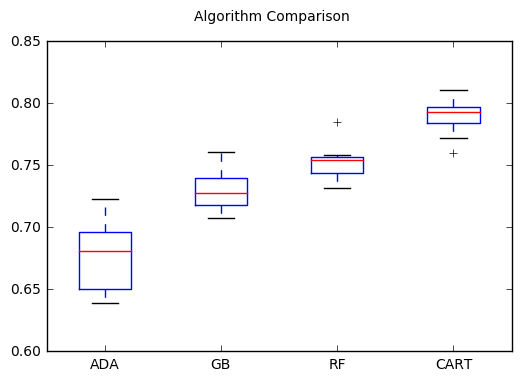

In [159]:
import warnings
warnings.filterwarnings('ignore')

# prepare models 
models = [] 
models.append(('ADA', AdaBoostClassifier())) 
models.append(('GB', GradientBoostingClassifier())) 
models.append(('RF', RandomForestClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
#models.append(('SVM', SVC()))

# evaluate each model in turn 
results = [] 
names = [] 

for name, model in models: 
    # Create pipeline
    estimators = []
#    estimators.append(('select_best', SelectKBest(k=28)))
    estimators.append(('model', model))
    pipeline = Pipeline(estimators)
    cv_results = cross_val_score(pipeline, X_train, Y_train, cv=kfold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) 
    print(msg)

# Compare models
fig = pyplot.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
pyplot.boxplot(results) 
ax.set_xticklabels(names) 
pyplot.show()

In [161]:
# Create the baseline model (the best one from model comparison task)

# Create pipeline
estimators = []
#estimators.append(('select_best', SelectKBest(k=28)))
estimators.append(('model', DecisionTreeClassifier(random_state = seed)))
baseline = Pipeline(estimators)
baseline.fit(X_train, Y_train)
#we can change param values -> baseline.set_params(select_best__k=8)

# Feature importance
#selector = baseline.named_steps['select_best']
#selectedFeatures = datasetHighImp.ix[:,selector.get_support()]
#model = baseline.named_steps['model']
#featureName = pd.DataFrame(selectedFeatures.columns, columns=['Feature'])
#featureImp = pd.DataFrame(model.feature_importances_, columns=['Imp'])
#pd.concat([featureName, featureImp], axis=1).to_csv('varImpTree.csv')

# Test the best model
predictions = baseline.predict(X_test)
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

[[1569  295]
 [ 260 1151]]
             precision    recall  f1-score   support

          0       0.86      0.84      0.85      1864
          1       0.80      0.82      0.81      1411

avg / total       0.83      0.83      0.83      3275



In [ ]:
import time
print(time.strftime("%H:%M:%S"))
# Model tuning for CART
model = DecisionTreeClassifier(random_state = seed)

# Grid search parameters
param_grid = {
    'criterion' : ["gini", "entropy"],
    'splitter' :   ["best", "random"],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [0.01, 0.0050, 0.0040, 0.0035, 0.0030],
    'min_samples_leaf' : [0.01, 0.0050, 0.0040, 0.0035, 0.0030],
    'max_depth': [10,20,25,30,40],
    'min_impurity_split' : [0.01, 0.0050, 0.0040, 0.0035, 0.0030],
    'class_weight': [{0:.1, 1:.9}, {0:.3, 1:.7}, "balanced"],
    'presort' : [True, False]
}

# Execute the grid search
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
CV_model_result = CV_model.fit(X_train, Y_train)

# Print results
print("Best: %f using %s" % (CV_model_result.best_score_, CV_model_result.best_params_))
print(time.strftime("%H:%M:%S"))

17:18:28


In [25]:
# Save the model to disk 
filename = 'binary_class_model.sav' 
dump(baseline, open(filename, 'wb'))

# load the model from disk 
#loaded_model = load(open(filename, 'rb')) 
#result = loaded_model.score(X_test, Y_test) 
#print(result)# Create the final model